In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import torch
import torch.nn as nn
import torch.nn.functional as F

In [113]:
# dataset load
data = pd.read_csv("/home/dataset/complete_dataset.csv")
# data_only_pm25 = pd.DataFrame(data.loc[:, ["PM-2.5", "일시"]])
data["일시"] = pd.to_datetime(data["일시"])
data.index = data["일시"]
del data["일시"]
data.head()

,평균기온(°C),최저기온(°C),최고기온(°C),강수 계속시간(hr),일강수량(mm),평균 풍속(m/s),최다풍향(16방위),최소 상대습도(%),평균 상대습도(%),평균 현지기압(hPa),...,일 최심적설(cm),평균 전운량(1/10),평균 지면온도(°C),최저 초상온도(°C),PM-10,PM-2.5,o3,no2,co,so2
일시,,,,,,,,,,,,,,,,,,,,,
2018-04-01,15.6,11.7,18.5,0.00,0.0,1.5,200.0,50.0,68.8,1006.3,...,0.0,9.1,14.3,6.2,57.0,27.0,0.028,0.039,0.5,0.004
2018-04-02,18.4,14.9,23.7,0.00,0.0,1.9,230.0,41.0,64.0,1005.4,...,0.0,6.1,17.8,11.1,58.0,21.0,0.028,0.039,0.5,0.005
2018-04-03,17.8,14.9,21.2,2.92,0.1,2.1,230.0,50.0,72.9,1006.4,...,0.0,9.1,17.2,13.8,61.0,16.0,0.018,0.042,0.5,0.005
2018-04-04,13.4,9.5,18.2,6.50,18.5,1.9,90.0,40.0,67.0,1007.4,...,0.0,6.1,15.9,7.9,9.0,4.0,0.024,0.031,0.4,0.003
2018-04-05,7.6,6.7,9.5,19.67,10.5,2.0,90.0,61.0,90.6,1005.7,...,0.0,9.9,8.9,6.2,5.0,3.0,0.015,0.039,0.5,0.003


In [106]:
class PatchTSDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_length:int=16, n_patches:int=6, prediction_length:int=4):
    self.P = patch_length # 44
    self.N = n_patches # 2
    self.L = int(patch_length * n_patches / 2)  # look-back window length = 44
    self.T = prediction_length
    self.data = ts

  def __len__(self):
    return len(self.data) - self.L - self.T + 1

  def __getitem__(self, i):
    look_back = self.data[i:(i+self.L)] # 44개
    look_back = np.concatenate([look_back, look_back[-1]*np.ones(int(self.P / 2), dtype=np.float32)])
    x = np.array([look_back[i*int(self.P/2):(i+2)*int(self.P/2)] for i in range(self.N)])
    y = self.data[(i+self.L):(i+self.L+self.T)]
    return x, y

In [125]:
from sklearn.preprocessing import MinMaxScaler

tst_size = 200
patch_length = 44
n_patches = 2
prediction_length = 4
window_size = int(patch_length * n_patches / 2)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.to_numpy(dtype=np.float32))

trn_list = [data_scaled[:-tst_size, i].flatten() for i in range(22)]
trn_ds_list = [PatchTSDataset(trn_list[i], patch_length, n_patches, prediction_length) for i in range(22)]

trn_ds = torch.utils.data.ConcatDataset(trn_ds_list)
trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
# trn = data[:-tst_size].to_numpy(dtype=np.float32).flatten()
# tst = data[-tst_size-window_size:].to_numpy(dtype=np.float32).flatten()
# scaler = MinMaxScaler()
# trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
# tst_scaled = scaler.transform(data[-tst_size-window_size:].to_numpy(dtype=np.float32)).flatten()

# trn_scaled.shape

In [117]:
scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(data.iloc[:, 17:18].to_numpy(dtype=np.float32))
tst = target_scaled[-tst_size-window_size:].flatten()
tst_ds = PatchTSDataset(tst, patch_length, n_patches)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [126]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 2, 44]), torch.Size([32, 4]))

In [121]:
class PatchTST(nn.Module):
  def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
    super(PatchTST, self).__init__()
    self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
    self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding

    encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    self.output_layer = nn.Linear(model_dim * n_token, output_dim)

  def forward(self, x):
    # x shape: (batch_size, n_token, token_size)
    x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
    x = x + self._pos
    x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
    x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
    output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4)
    return F.sigmoid(output)

In [130]:
from tqdm.auto import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PatchTST(n_patches, patch_length, 128, 8, 4, prediction_length)
model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

pbar = trange(10)
for _ in pbar:
  model.train()
  trn_loss = 0.
  for x,y in trn_dl:
    x, y = x.to(device), y.to(device)
    p = model(x)
    # print(x.shape, y.shape)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(trn_ds)

  model.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.to(device), y.to(device)
    p = model(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/10 [00:00<?, ?it/s]

In [123]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

torch.Size([197, 4])
torch.Size([197, 4])
(197, 4) (197, 4)
(200,) (200,)


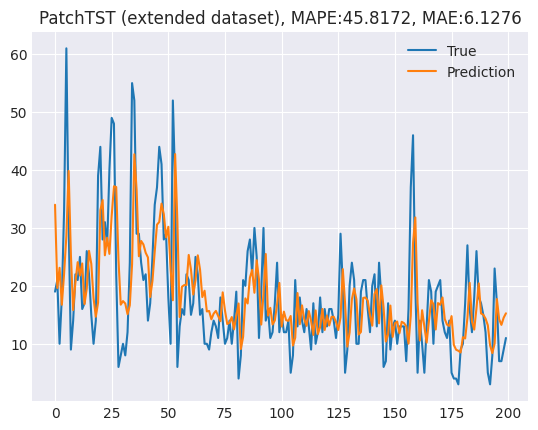

In [131]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.to(device), y.to(device)
  p = model(x)
  print(y.shape)
  print(p.shape)

y = scaler_target.inverse_transform(y.cpu())
p = scaler_target.inverse_transform(p.cpu())

print(y.shape, p.shape)
y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])
print(y.shape, p.shape)

plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

# res_dict.update({'PatchTST/8': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})